In [1]:
from utils import (
    Timer,
    PerformanceMonitor,
    MemoryMonitor,
    PerfLogger,
    LoggedPerformanceMonitor,
    PollingLoggedPerformanceMonitor,
)
import numpy as np
import gc

In [2]:
# Example 1: Using Timer only
a = np.random.rand(1000000)
b = np.random.rand(1000000)
with Timer("Add Operation"):
    c = a + b
del a, b, c

Execution time for Add Operation is 0.003038 s


In [3]:
# Example 2: Using MemoryMonitor only
with MemoryMonitor("Large Array Creation"):
    large_array = np.random.rand(5000000)  # ~40MB array
    processed_array = large_array * 2 + 1
    del large_array  # Explicitly delete to free memory

Memory usage for Large Array Creation:
  Start: 109.99 MB
  End: 148.14 MB
  Net change: +38.15 MB
  Peak increase: +0.00 MB


In [4]:
# Example 3: Using PerformanceMonitor for comprehensive analysis
with PerformanceMonitor("Matrix Operations"):
    # Create large matrices
    matrix_a = np.random.rand(2000, 2000)
    matrix_b = np.random.rand(2000, 2000)

    # Perform memory-intensive operations
    result = np.dot(matrix_a, matrix_b)
    eigenvalues = np.linalg.eigvals(result[:100, :100])  # Small subset for speed

    # Clean up
    del matrix_a, matrix_b, result

Execution time for Matrix Operations is 0.482387 s
Memory usage for Matrix Operations:
  Start: 148.18 MB
  End: 159.18 MB
  Net change: +11.00 MB
  Peak increase: +0.00 MB
--- End of Matrix Operations performance report ---



In [5]:
# Example 4: Demonstrate transient peak memory increase
with MemoryMonitor("Transient Peak Example") as mm:
    # Start with a small allocation
    a = np.random.rand(1000000)
    mm.update_peak()  # record current memory as peak so far

    # Create a transient large allocation that should raise peak
    temp = np.random.rand(8000000)  # transient large array
    mm.update_peak()  # update peak after transient allocation

    # Use the temporary array briefly
    s = temp.sum()

    # Remove the temporary allocation and force GC
    del temp
    gc.collect()

    # Final small operation
    a = a * 2
    del a

# The MemoryMonitor should report a peak increase above the start memory.

Memory usage for Transient Peak Example:
  Start: 159.20 MB
  End: 159.20 MB
  Net change: +0.01 MB
  Peak increase: +68.67 MB


In [6]:
# Usage example: poll-backed logger to reliably capture transient peak
perf_logger = PerfLogger()
with PollingLoggedPerformanceMonitor(
    "Polled Transient Peak", perf_logger, poll_interval=0.005
):
    temp = np.random.rand(8000000)
    s = temp.sum()
    del temp
    gc.collect()

# Convert logs to DataFrame and display
perf_df = perf_logger.to_dataframe()
print(perf_df.to_string(index=False))

Execution time for Polled Transient Peak is 0.295633 s
Memory usage for Polled Transient Peak:
  Start: 159.22 MB
  End: 159.22 MB
  Net change: +0.00 MB
  Peak increase: +61.06 MB
                 name   start_time     end_time  duration_s  start_mem_mb  end_mem_mb  net_mem_change_mb  peak_mem_mb  peak_increase_mb
Polled Transient Peak 1.904327e+06 1.904328e+06    0.295648     159.21875   159.21875                0.0   220.277344         61.058594


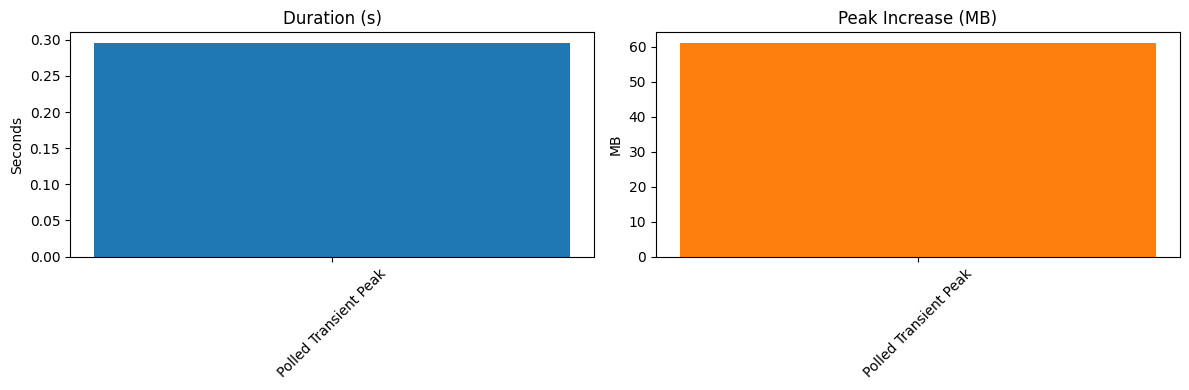

In [7]:
# Plotting: visualize duration and peak increase
import matplotlib.pyplot as plt

# If perf_df doesn't exist (run the previous logging cell), recreate from logger
try:
    perf_df
except NameError:
    perf_df = perf_logger.to_dataframe()

if perf_df.empty:
    print("No records to plot")
else:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Duration bar chart
    axes[0].bar(perf_df["name"], perf_df["duration_s"], color="tab:blue")
    axes[0].set_title("Duration (s)")
    axes[0].set_ylabel("Seconds")
    axes[0].tick_params(axis="x", rotation=45)

    # Peak increase bar chart
    axes[1].bar(perf_df["name"], perf_df["peak_increase_mb"], color="tab:orange")
    axes[1].set_title("Peak Increase (MB)")
    axes[1].set_ylabel("MB")
    axes[1].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()
